# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split

## Important Parameters

In [2]:
# training hyperparameters
learning_rate = 0.001
epochs = 10
batch_size = 32

# train and validation split
train_split = 0.8
val_split = 1 - train_split

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
#!pip install ipywidgets
# Define transforms
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307), (0.3081))])

#Create training and validation sets
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_samples = int(len(train_dataset) * train_split)
val_samples = int(np.ceil((len(train_dataset) * val_split)))
print("Training Samples = {}\nValidation Samples = {}".format(train_samples,val_samples))
train_data, val_data = random_split(train_dataset, [train_samples, val_samples],
                                   generator=torch.Generator().manual_seed(42))
#Define train and val dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

#Create test set and define test dataloader
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=batch_size)
print("Testing Samples = ",len(test_data))

#Calculate training and validation steps
train_steps = train_samples // batch_size
val_steps = val_samples // batch_size
print("\nTrain Steps = {}\nValidation Steps = {}".format(train_steps, val_steps))

Training Samples = 48000
Validation Samples = 12000
Testing Samples =  10000

Train Steps = 1500
Validation Steps = 375


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

 - **I am converting the dataset to torch tensors since pytorch works on it**
 - **The normalization is along one channel since MNIST has grayscale images**
 - **I have not flatten the input because I am using convolution layers**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T,cmap='gray')
        plt.show()

2


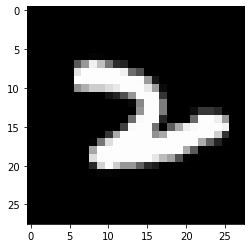

8


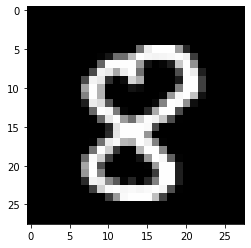

7


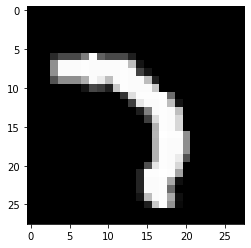

9


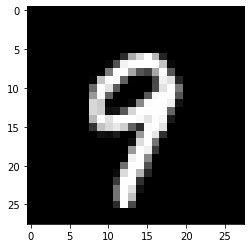

2


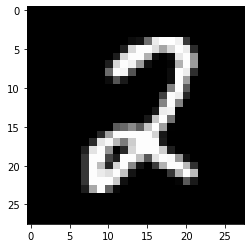

In [5]:
# Explore data
show5(val_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=[3, 3], stride=[1, 1])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=[3, 3], stride=[2, 2])
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc1 = nn.Linear(576, 288)
        self.fc2 = nn.Linear(288, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
 
        x = self.fc2(x)
        x = self.logsoftmax(x)
        return x


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
train_loss_history = list()
train_acc_history = list()
val_loss_history = list()
val_acc_history = list()

print("Using ",device)

for epoch in range(epochs):
    model.train()    
    #correct number of predictions
    val_correct = 0
    train_correct = 0  
    # total training and validation loss
    total_train_loss = 0.0
    total_val_loss = 0.0
    
    for data in train_loader:
        # data is a list of [inputs, labels]
        inputs, labels = data
        # Pass to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass and loss
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Calculate training loss and correct predictions
        total_train_loss += loss
        train_correct += (outputs.argmax(1)==labels).type(torch.float).sum().item()
    
    # Evaluation
    with torch.no_grad():
        model.eval()
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss
            val_correct += (outputs.argmax(1)==labels).type(torch.float).sum().item()
    
    # Calculate average loss
    avg_training_loss = total_train_loss / train_steps
    avg_val_loss = total_val_loss / val_steps
    
    # Calculate average accuracy
    avg_training_acc = train_correct / train_samples
    avg_val_acc = val_correct / val_samples
    
    # Update History
    train_loss_history.append(avg_training_loss.cpu().detach().numpy())
    train_acc_history.append(avg_training_acc)
    val_loss_history.append(avg_val_loss.cpu().detach().numpy())
    val_acc_history.append(avg_val_acc)
    
    print("Epoch {}/{}".format(epoch+1, epochs))
    print("Training Acc = {:.4f}\tValidation Acc = {:.4f}".format(avg_training_acc*100, avg_val_acc*100))
    print("Training Loss = {:.4f}\tValidation Loss = {:.4f}\n".format(avg_training_loss, avg_val_loss))
    


Using  cuda
Epoch 1/10
Training Acc = 38.9854	Validation Acc = 60.9333
Training Loss = 2.1659	Validation Loss = 1.8669

Epoch 2/10
Training Acc = 73.8521	Validation Acc = 81.2500
Training Loss = 1.1693	Validation Loss = 0.7181

Epoch 3/10
Training Acc = 84.9979	Validation Acc = 86.8917
Training Loss = 0.5510	Validation Loss = 0.4707

Epoch 4/10
Training Acc = 88.6896	Validation Acc = 89.3583
Training Loss = 0.3973	Validation Loss = 0.3716

Epoch 5/10
Training Acc = 90.8312	Validation Acc = 91.2583
Training Loss = 0.3206	Validation Loss = 0.3102

Epoch 6/10
Training Acc = 92.2396	Validation Acc = 92.1917
Training Loss = 0.2711	Validation Loss = 0.2709

Epoch 7/10
Training Acc = 93.2375	Validation Acc = 93.2000
Training Loss = 0.2351	Validation Loss = 0.2401

Epoch 8/10
Training Acc = 93.9021	Validation Acc = 93.7500
Training Loss = 0.2094	Validation Loss = 0.2160

Epoch 9/10
Training Acc = 94.5833	Validation Acc = 93.9000
Training Loss = 0.1888	Validation Loss = 0.2021

Epoch 10/10
Trai

Plot the training loss (and validation loss/accuracy, if recorded).

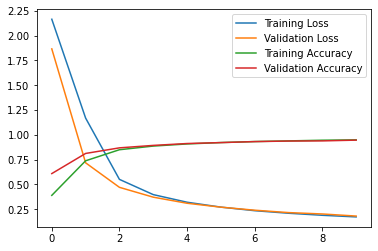

In [9]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.plot(train_acc_history, label="Training Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
with torch.no_grad():
    model.eval()
    test_correct = 0
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_correct += (outputs.argmax(1)==labels).type(torch.float).sum().item()
    avg_test_acc = test_correct / len(test_data)
    print("Test Accuracy = {:.4f}".format(avg_test_acc * 100))

Test Accuracy = 95.5000


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

Using  cuda
Epoch 1/10
Training Acc = 94.4562	Validation Acc = 97.7500
Training Loss = 0.1721	Validation Loss = 0.0674

Epoch 2/10
Training Acc = 98.1146	Validation Acc = 98.1250
Training Loss = 0.0592	Validation Loss = 0.0630

Epoch 3/10
Training Acc = 98.6792	Validation Acc = 97.9833
Training Loss = 0.0412	Validation Loss = 0.0676

Epoch 4/10
Training Acc = 98.9604	Validation Acc = 98.4250
Training Loss = 0.0312	Validation Loss = 0.0533

Epoch 5/10
Training Acc = 99.2729	Validation Acc = 98.4917
Training Loss = 0.0223	Validation Loss = 0.0535

Epoch 6/10
Training Acc = 99.3396	Validation Acc = 98.5833
Training Loss = 0.0200	Validation Loss = 0.0515

Epoch 7/10
Training Acc = 99.4667	Validation Acc = 98.5500
Training Loss = 0.0161	Validation Loss = 0.0604

Epoch 8/10
Training Acc = 99.5792	Validation Acc = 98.7000
Training Loss = 0.0131	Validation Loss = 0.0569

Epoch 9/10
Training Acc = 99.5833	Validation Acc = 98.6167
Training Loss = 0.0134	Validation Loss = 0.0569

Epoch 10/10
Trai

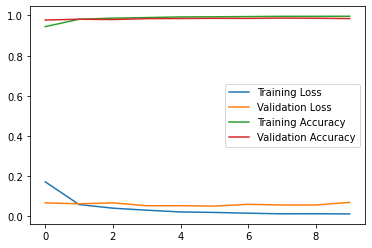

Test Accuracy = 98.6200


In [13]:
#changing optimizer from SGD to Adam
model1 = Net().to(device)
criterion1 = nn.NLLLoss()
optimizer1 = optim.Adam(model1.parameters(), lr = learning_rate)

train_loss_history = list()
train_acc_history = list()
val_loss_history = list()
val_acc_history = list()

print("Using ",device)

for epoch in range(epochs):
    model1.train()    
    #correct number of predictions
    val_correct = 0
    train_correct = 0  
    # total training and validation loss
    total_train_loss = 0.0
    total_val_loss = 0.0
    
    for data in train_loader:
        # data is a list of [inputs, labels]
        inputs, labels = data
        # Pass to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass and loss
        outputs = model1(inputs)
        loss = criterion1(outputs, labels)
        # Backpropagation
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        # Calculate training loss and correct predictions
        total_train_loss += loss
        train_correct += (outputs.argmax(1)==labels).type(torch.float).sum().item()
    
    # Evaluation
    with torch.no_grad():
        model1.eval()
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model1(inputs)
            loss = criterion1(outputs, labels)
            total_val_loss += loss
            val_correct += (outputs.argmax(1)==labels).type(torch.float).sum().item()
    
    # Calculate average loss
    avg_training_loss = total_train_loss / train_steps
    avg_val_loss = total_val_loss / val_steps
    
    # Calculate average accuracy
    avg_training_acc = train_correct / train_samples
    avg_val_acc = val_correct / val_samples
    
    # Update History
    train_loss_history.append(avg_training_loss.cpu().detach().numpy())
    train_acc_history.append(avg_training_acc)
    val_loss_history.append(avg_val_loss.cpu().detach().numpy())
    val_acc_history.append(avg_val_acc)
    
    print("Epoch {}/{}".format(epoch+1, epochs))
    print("Training Acc = {:.4f}\tValidation Acc = {:.4f}".format(avg_training_acc*100, avg_val_acc*100))
    print("Training Loss = {:.4f}\tValidation Loss = {:.4f}\n".format(avg_training_loss, avg_val_loss))

plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.plot(train_acc_history, label="Training Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.legend()
plt.show()

with torch.no_grad():
    model1.eval()
    test_correct = 0
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model1(inputs)
        test_correct += (outputs.argmax(1)==labels).type(torch.float).sum().item()
    avg_test_acc = test_correct / len(test_data)
    print("Test Accuracy = {:.4f}".format(avg_test_acc * 100))

## Saving your model
Using `torch.save`, save your model for future loading.

In [14]:
torch.save(model, "model.pth")

In [15]:
torch.save(model1, "model1.pth")